In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
import numpy as np

In [16]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [17]:
file_path = '../data/energies/Trial/Strings_Energies_10_000.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [18]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [19]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [20]:
def qml_RZZ(params, wires):
    """
    RZZ gate.
    """
    qml.CNOT(wires=wires)
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=wires)

In [21]:
import pennylane as qml

n_qubits = 12
n_layers_block = 5
n_layers_embedding = 3
n_layers = n_layers_block + n_layers_embedding
n_params = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    # state preparation (we create an embedding with 3 layers, paper: 2001.03622)
    for i in range(n_layers_embedding):
       
        # angle embedding for each qubit
        qml.AngleEmbedding(inputs, wires=range(n_qubits))

        # ZZ rotation for neighboring qubits         
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,0], wires=[j, (j+1)%n_qubits])

        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights[i,j,1], wires=j)

        # last angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #layers
    for i in range(n_layers_embedding, n_layers):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RX(weights[i,j,2], wires=j)
            qml.RZ(weights[i,j,3], wires=j)

        # ZZ rotation for neighboring qubits 
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,4], wires=[j, (j+1)%n_qubits])

    # measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

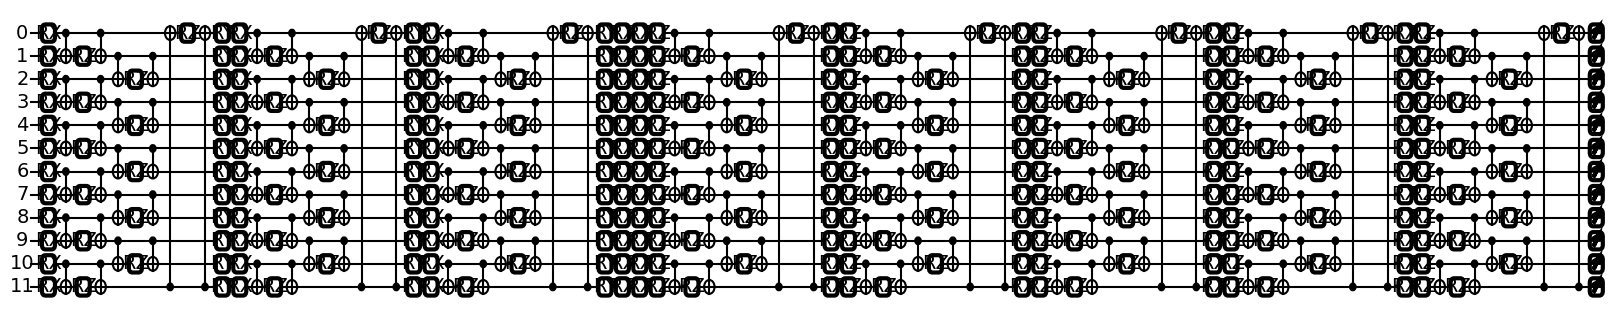

In [22]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(12)], np.zeros((n_layers, n_qubits, n_params)))
fig.set_size_inches((16,3))

In [23]:
weight_shapes = {"weights": (n_layers, n_qubits, n_params)}

In [24]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Classical model

In [25]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1)] 
layers += [qlayer] 
layers += [nn.Linear(input_dim*1, input_dim*1), nn.ReLU()] 
layers += [nn.Linear(input_dim*1, 1          ), nn.ReLU()] 
Net = nn.Sequential(*layers)

In [26]:
# Create an instance of the network
model = Net

In [27]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
num_epochs = 1
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()))

    losses_epochs.append(criterion(input_data, target_data).item())

    # Print the loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


- Epoch [1/1], i: [0/9000], Loss: 25.4654
- Epoch [1/1], i: [32/9000], Loss: 26.0075
- Epoch [1/1], i: [64/9000], Loss: 20.6748
- Epoch [1/1], i: [96/9000], Loss: 29.2350
- Epoch [1/1], i: [128/9000], Loss: 22.5415
- Epoch [1/1], i: [160/9000], Loss: 15.0319
- Epoch [1/1], i: [192/9000], Loss: 21.8055
- Epoch [1/1], i: [224/9000], Loss: 31.5412
- Epoch [1/1], i: [256/9000], Loss: 30.6180
- Epoch [1/1], i: [288/9000], Loss: 17.7502
- Epoch [1/1], i: [320/9000], Loss: 27.3591
- Epoch [1/1], i: [352/9000], Loss: 18.6410
- Epoch [1/1], i: [384/9000], Loss: 31.7717
- Epoch [1/1], i: [416/9000], Loss: 22.9022
- Epoch [1/1], i: [448/9000], Loss: 27.2088
- Epoch [1/1], i: [480/9000], Loss: 21.7323
- Epoch [1/1], i: [512/9000], Loss: 22.4632
- Epoch [1/1], i: [544/9000], Loss: 21.1093
- Epoch [1/1], i: [576/9000], Loss: 24.8590
- Epoch [1/1], i: [608/9000], Loss: 21.5665
- Epoch [1/1], i: [640/9000], Loss: 29.3685
- Epoch [1/1], i: [672/9000], Loss: 28.2883
- Epoch [1/1], i: [704/9000], Loss: 2

d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([9000, 1])) that is different to the input size (torch.Size([9000, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


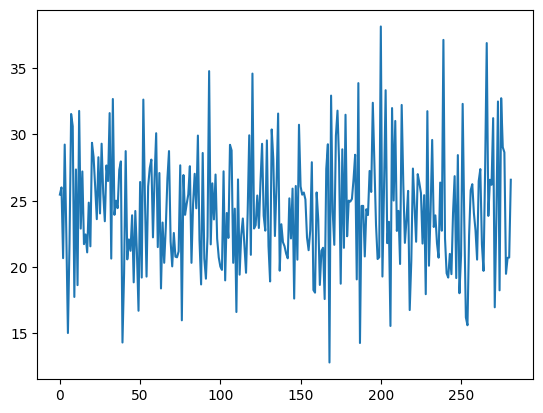

In [28]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

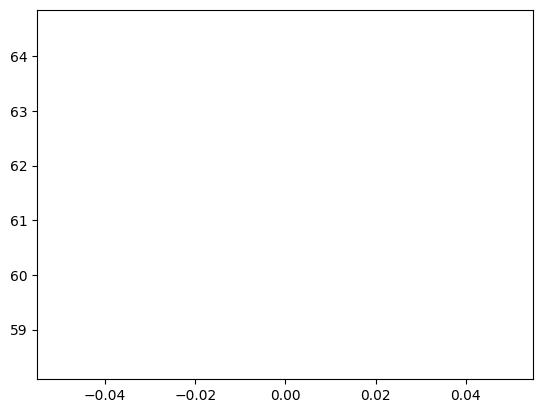

In [29]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [30]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, target: {:.3f}, output: {:.3f}, loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))
    print('')

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, target: 4.751, output: 0.000, loss: 22.574

i: 1, target: 7.348, output: 0.000, loss: 53.989

i: 2, target: 7.501, output: 0.000, loss: 56.262

i: 3, target: 3.801, output: 0.000, loss: 14.450

i: 4, target: 0.759, output: 0.000, loss: 0.575

i: 5, target: 3.659, output: 0.000, loss: 13.385

i: 6, target: 2.670, output: 0.000, loss: 7.127

i: 7, target: 5.412, output: 0.000, loss: 29.295

i: 8, target: 6.172, output: 0.000, loss: 38.098

i: 9, target: 6.088, output: 0.000, loss: 37.070

i: 10, target: 5.794, output: 0.000, loss: 33.576

i: 11, target: 4.941, output: 0.000, loss: 24.416

i: 12, target: 3.658, output: 0.000, loss: 13.380

i: 13, target: 3.883, output: 0.000, loss: 15.075

i: 14, target: 2.566, output: 0.000, loss: 6.582

i: 15, target: 5.410, output: 0.000, loss: 29.271

i: 16, target: 2.223, output: 0.000, loss: 4.942

i: 17, target: 3.735, output: 0.000, loss: 13.951

i: 18, target: 3.954, output: 0.000, loss: 15.633

i: 19, target: 4.084, output: 0.000, loss: 16

KeyboardInterrupt: 